In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar -xzf food-101.tar.gz


--2025-12-29 16:38:11--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2025-12-29 16:38:12--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  16.7MB/s    in 4m 49s  

2025-12-29 16:43:02 (16.5 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [ ]:
import os, shutil, random

base_dir = 'food-101/images'
train_dir = 'data/train'
val_dir = 'data/val'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
all_classes = os.listdir(base_dir)
selected_classes = random.sample(all_classes, 25)
for cls in selected_classes:
    images = os.listdir(os.path.join(base_dir, cls))
    random.shuffle(images)

    train_images = images[:200]
    val_images = images[200:250]


    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    for img in train_images:
        shutil.copy(os.path.join(base_dir, cls, img),
                    os.path.join(train_dir, cls, img))

    for img in val_images:
        shutil.copy(os.path.join(base_dir, cls, img),
                    os.path.join(val_dir, cls, img))


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input


IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 5000 images belonging to 25 classes.
Found 1250 images belonging to 25 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(25, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 109s 547ms/step - accuracy: 0.6296 - loss: 1.2156 - val_accuracy: 0.7128 - val_loss: 0.9382
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 64s 408ms/step - accuracy: 0.6962 - loss: 0.9769 - val_accuracy: 0.7192 - val_loss: 0.8938
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 419ms/step - accuracy: 0.7451 - loss: 0.8273 - val_accuracy: 0.7320 - val_loss: 0.8535
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 400ms/step - accuracy: 0.7828 - loss: 0.7249 - val_accuracy: 0.7384 - val_loss: 0.8358
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 403ms/step - accuracy: 0.8003 - loss: 0.6339 - val_accuracy: 0.7552 - val_loss: 0.8222
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 64s 407ms/step - accuracy: 0.8332 - loss: 0.5711 - val_accuracy: 0.7656 - val_loss: 0.8053
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 404ms/step - accuracy: 0.8446 - loss: 0.5175 - val_accuracy: 0.7632 - val_loss: 0.7963
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 65s 417ms/step - accuracy: 0.8586 - loss: 

In [ ]:
# Unfreeze top layers for fine-tuning
for layer in base_model.layers[-20:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # VERY important
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=3
)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 108s 543ms/step - accuracy: 0.9084 - loss: 0.3159 - val_accuracy: 0.7816 - val_loss: 0.7705
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 399ms/step - accuracy: 0.9082 - loss: 0.3112 - val_accuracy: 0.7864 - val_loss: 0.7694
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 62s 397ms/step - accuracy: 0.9003 - loss: 0.3260 - val_accuracy: 0.7824 - val_loss: 0.7722


In [ ]:
class_names = list(train_data.class_indices.keys())
print(class_names)


['apple_pie', 'baklava', 'beet_salad', 'caprese_salad', 'carrot_cake', 'chicken_quesadilla', 'clam_chowder', 'crab_cakes', 'deviled_eggs', 'edamame', 'fish_and_chips', 'fried_calamari', 'frozen_yogurt', 'greek_salad', 'grilled_salmon', 'hamburger', 'ice_cream', 'miso_soup', 'peking_duck', 'pork_chop', 'ravioli', 'risotto', 'strawberry_shortcake', 'sushi', 'tuna_tartare']


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_image(img_path, model):
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)   # shape (1,224,224,3)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)

    return predicted_class, confidence


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving cq.jpg to cq.jpg


In [ ]:
img_path = list(uploaded.keys())[0]
label, conf = predict_image(img_path, model)

print(f"Predicted class: {label}")
print(f"Confidence: {conf:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted class: chicken_quesadilla
Confidence: 1.00


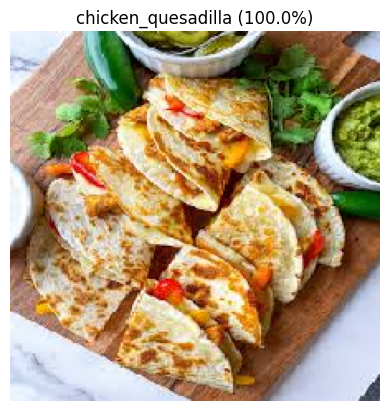

In [ ]:
import matplotlib.pyplot as plt

img = tf.keras.utils.load_img(img_path, target_size=(224,224))
plt.imshow(img)
plt.axis('off')
plt.title(f"{label} ({conf*100:.1f}%)")
plt.show()


In [ ]:
print("Train classes:", train_data.class_indices)
print("Val classes:", val_data.class_indices)


Train classes: {'apple_pie': 0, 'baklava': 1, 'beet_salad': 2, 'caprese_salad': 3, 'carrot_cake': 4, 'chicken_quesadilla': 5, 'clam_chowder': 6, 'crab_cakes': 7, 'deviled_eggs': 8, 'edamame': 9, 'fish_and_chips': 10, 'fried_calamari': 11, 'frozen_yogurt': 12, 'greek_salad': 13, 'grilled_salmon': 14, 'hamburger': 15, 'ice_cream': 16, 'miso_soup': 17, 'peking_duck': 18, 'pork_chop': 19, 'ravioli': 20, 'risotto': 21, 'strawberry_shortcake': 22, 'sushi': 23, 'tuna_tartare': 24}
Val classes: {'apple_pie': 0, 'baklava': 1, 'beet_salad': 2, 'caprese_salad': 3, 'carrot_cake': 4, 'chicken_quesadilla': 5, 'clam_chowder': 6, 'crab_cakes': 7, 'deviled_eggs': 8, 'edamame': 9, 'fish_and_chips': 10, 'fried_calamari': 11, 'frozen_yogurt': 12, 'greek_salad': 13, 'grilled_salmon': 14, 'hamburger': 15, 'ice_cream': 16, 'miso_soup': 17, 'peking_duck': 18, 'pork_chop': 19, 'ravioli': 20, 'risotto': 21, 'strawberry_shortcake': 22, 'sushi': 23, 'tuna_tartare': 24}


In [ ]:
# import shutil
# shutil.rmtree('data', ignore_errors=True)

In [ ]:
model.save('food_classifier_50.keras')
